ANN using gradient policy for training (Parallel training with multiple agents)

A problem that this has is that sometimes, it gets stuck in a local minimum. Thats why maybe PPO would be a better approach. => The solution was reducing the learning rate.

In [9]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import numpy as np
import gymnasium as gym  
import warnings
import random
import time

In [10]:
# Making the gymnasium environment
env = gym.make("CartPole-v1")

# Define the network
class policyNetwork(nn.Module):
    def __init__(self, inputDim, hiddenDim, outDim, dropOut):
        super().__init__()
        self.layer1 = nn.Linear(inputDim, hiddenDim)
        self.layer2 = nn.Linear(hiddenDim, outDim)
        self.dropout = nn.Dropout(dropOut)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.dropout(x1)
        x3 = F.relu(x2)
        x4 = self.layer2(x3)
        return x4

# Calculate the cumulative returns in a specific trajectory
def cumulativeReturn(trajectoryRewards, gamma):
    # gamma is the discount factor
    
    returns = []
    __R = 0
    
    for reward in reversed(trajectoryRewards):
        __R = reward + gamma * __R
        returns.insert(0, __R)
    
    returns = torch.tensor(returns)
    
    # Normalize the returns
    return (returns - returns.mean())/(returns.std() + 1e-9)

def cumulativeReturn_vectorized(rewards, gamma):
    """
    Compute stepwise returns with a discount factor using a vectorized approach in PyTorch.
    Explanation link: https://x.com/i/grok/share/1SAiyt3UzyHHDIE6h3ALxCyz2
    
    Parameters:
    - rewards: 1D torch tensor of shape (T,) containing the reward sequence [r_0, r_1, ..., r_{T-1}]
    - gamma: float, discount factor between 0 and 1
    
    Returns:
    - returns: 1D torch tensor of shape (T,) containing [G_0, G_1, ..., G_{T-1}]
    """
    # Ensure rewards is a 1D tensor
    assert rewards.dim() == 1, "rewards must be a 1D tensor"
    # print("input", rewards)
    T = rewards.size(0)
    # Create indices for broadcasting
    indices = torch.arange(T)
    # Compute exponents (j - i) using broadcasting
    exponents = indices[None, :] - indices[:, None]
    # Construct the upper triangular matrix A
    A = torch.where(exponents >= 0, gamma ** exponents.float(), torch.zeros_like(exponents).float())
    # Compute returns via matrix multiplication
    returns = A @ rewards
    return (returns - returns.mean())/(returns.std() + 1e-9)

In [ ]:
# Synchronous environments (Network updates when all agents are done)
# Works perfectly fine

def forwardPass(envs, policyNetwork, discountFactor):
    """
    Runs a forward pass through all environments and only after all of them are done
    the pass finishes. After termination of each environment, the accumulation of 
    the environment's data stops; however, when envs.step(...) is ran, the terminated
    environments are restarted and continued. This approach has been employed because 
    Gymnasium currently doesn't support running steps for particular environments, or
    restarting particular environments.

    Args:
        envs (gymnasium vector environment): A gymnasium vector environment
        policyNetwork (torch.nn): The network we are trying to learn
        discountFactor (float): the discount factor to calculate rewards in a trajectory

    Returns:
        overallRewards: The accumulated reward of each agent's trajectory
        trajectoryRewards: A list of pyTorch tensors
        log_probActions: A list of pyTorch tensors
    """
    log_probActions = [[] for _ in range(NUM_ENVS)]
    rewards_hist = [[] for _ in range(NUM_ENVS)]
    
    activeEpisodes =  torch.ones(NUM_ENVS, dtype = torch.bool)
    
    states, _ = envs.reset(seed = random.randint(1,1_000_000_000))
    
    while True:
        actionPred = policyNetwork(torch.Tensor(states[:,:4]))
        actionProb = F.softmax(actionPred, dim = -1)
        dist = distributions.Categorical(actionProb)
        action = dist.sample()
        
        states, rewards, terminated, truncated, _ = envs.step(action.numpy())

        # Gather logarithm of actions and rewards for active envs (envs that are 
        # not terminated or truncated)
        for idx in range(NUM_ENVS):
            # Only add history if the episode has not been truncated
            if activeEpisodes[idx]:
                log_probActions[idx].append(dist.log_prob(action).unsqueeze(-1)[0])
                rewards_hist[idx].append(torch.tensor(rewards[idx], dtype = torch.float).unsqueeze(-1))

        # If an env is terminated or truncated, take it off the active env list
        if ((terminated | truncated).any()):
            _terminated = np.where((terminated | truncated) == True)[0]
            for idx in _terminated: activeEpisodes[idx] = False
        
        # If all envs are terminated or truncated, stop the forward pass
        if not activeEpisodes.any():
            overallRewards = [torch.tensor(rewards_hist[idx], dtype = torch.float).sum().item() for idx in range(NUM_ENVS)]
            trajectoryRewards = [cumulativeReturn_vectorized(torch.cat(rewards_hist[idx]), discountFactor) for idx in range(NUM_ENVS)]
            log_probActions = [torch.cat(log_probActions[idx]) for idx in range(NUM_ENVS)]
            break
    
    return overallRewards, trajectoryRewards, log_probActions


NUM_ENVS = 10
envs = gym.make_vec(
    "CartPole-v1", 
    num_envs = NUM_ENVS, # Number of environments to create
    vectorization_mode = "async",
    wrappers = (gym.wrappers.TimeAwareObservation,),
)
env = gym.make("CartPole-v1")

# Async version with forward pass as a single function.
# Hyperparameters
MAX_EPOCHS = 5000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_INTERVAL = 10
INPUT_DIM = env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = env.action_space.n
DROPOUT = 0.5

episodeReturns = []
policy = policyNetwork(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
optimizer = optim.Adam(policy.parameters(), lr = 0.001)


mean_episode_return = 0
episode = 0
tmp_lstLoss = []

states, _ = envs.reset()
overallTimeStep = 0
# Setup the environment
policy.train()
_startTime = time.time()
while True:
    overallRewards, trajectoryRewards, log_probActions = forwardPass(envs, policy, DISCOUNT_FACTOR)

    _loss = 0
    # Compute loss
    for idx in range(NUM_ENVS):
        _loss += -(log_probActions[idx] * trajectoryRewards[idx]).sum()
        # print( -(log_probActions[idx] * trajectoryRewards[idx]).sum(), _loss)
    
    __loss = _loss / NUM_ENVS
    tmp_lstLoss.append(__loss.unsqueeze(0))
    
    optimizer.zero_grad()
    __loss.backward()
    optimizer.step()
    
    for _ep in overallRewards: episodeReturns.append(_ep)
    mean_episode_return = np.mean(episodeReturns[-N_TRIALS:])

    if episode % PRINT_INTERVAL == 0:
        print(f'Episode: {episode:3} | Mean Rewards: {mean_episode_return:5.1f} | tps: {overallTimeStep/(time.time()-_startTime):.2f}', end="\r")

    if mean_episode_return >= REWARD_THRESHOLD:
        print(f'\nReached reward threshold in {episode} forward passes')
        break

    episode = episode + 1
    overallTimeStep = overallTimeStep + max(map(len,trajectoryRewards))

Episode: 3990 | Mean Rewards: 197.0 | tps: 793.69
Reached reward threshold in 3991 forward passes


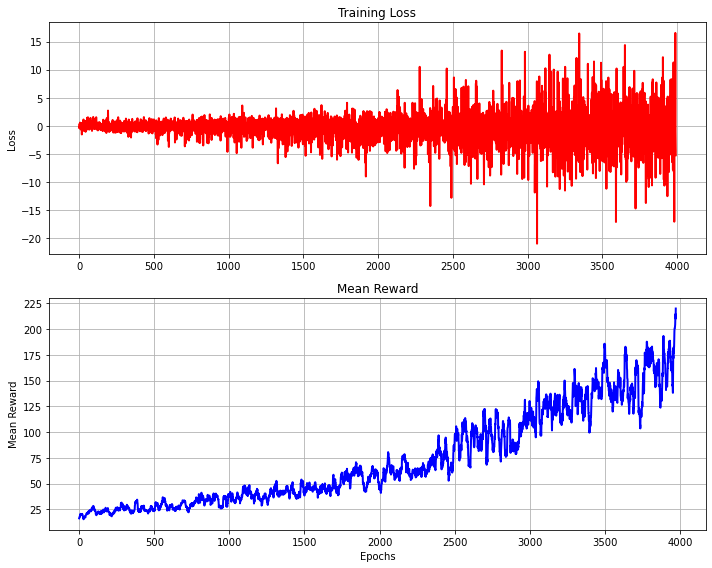

In [15]:
import matplotlib.pyplot as plt
window_size = 20
rolling_avg = np.convolve(np.array(episodeReturns), np.ones(window_size)/window_size, mode='valid')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss
ax1.plot( torch.cat(tmp_lstLoss).detach().numpy(), 'r-', linewidth=2)
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot mean reward
ax2.plot(rolling_avg, 'b-', linewidth=2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Reward')
ax2.set_title('Mean Reward')
ax2.grid(True)

plt.tight_layout()
plt.show()